# Import statements

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='/home/ubuntu/fastai/mercari/data/'

In [3]:
!ls data

models	sample_submission.csv  test.tsv  tmp  train.tsv


In [4]:
train = pd.read_csv(f'{PATH}train.tsv', sep='\t')

In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
test = pd.read_csv(f'{PATH}test.tsv', sep='\t')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


# Feature creation

In [27]:
cat_vars = [ 'category_name',  'brand_name', 'shipping', 'item_description']
contin_vars = ['item_condition_id']

In [28]:
dep = 'price'
test[dep] = 0
joined = train[cat_vars+contin_vars+[dep,'name']].copy()
joined_test = test[cat_vars+contin_vars+[dep, 'name',  'test_id']].copy()

In [29]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [30]:
apply_cats(joined_test, joined)

In [31]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [ ]:
#joined['item_condition_id'] = joined.item_condition_id.astype(np.int32)
#joined['shipping'] = joined.shipping.astype(np.int32)
#joined_test['item_condition_id'] = joined_test.item_condition_id.astype(np.int32)
#joined_test['shipping'] = joined_test.shipping.astype(np.int32)

In [32]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("name")
samp_size = len(joined_samp); samp_size

150000

In [ ]:
??get_cv_idxs

In [33]:
n = len(joined)
samp_size = n
joined_samp = joined

In [24]:
joined_samp.head()

,category_name,brand_name,shipping,item_description,item_condition_id,price,name
0,Men/Tops/T-shirts,NaN,1,No description yet,3.0,10.0,MLB Cincinnati Reds T Shirt Size XL
1,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,3.0,52.0,Razer BlackWidow Chroma Keyboard
2,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,1.0,10.0,AVA-VIV Blouse
3,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,1.0,35.0,Leather Horse Statues
4,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,1.0,44.0,24K GOLD plated rose


In [ ]:
#??proc_df

In [ ]:
len(joined_samp)

In [25]:
joined_test = joined_test

In [34]:
joined_test = joined_test.set_index("name")
joined = joined.set_index("name")

In [35]:
df, y, nas, mapper = proc_df(joined, 'price', do_scale=True)
yl = np.log(y)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [36]:
df_test, _, nas, mapper = proc_df(joined_test, 'price', do_scale=True, skip_flds=['test_id'],
                                  mapper=mapper, na_dict=nas)
#for n,c in joined_samp.items(): print(n), print(c)

In [37]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
np.unique()

In [ ]:
len(val_idx)

In [ ]:
val_idx[1:5]

In [ ]:
df.head()

In [ ]:
len(joined)

In [ ]:
df_test.head()

In [ ]:
df['name']

In [38]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [39]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [40]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [41]:
cat_sz

[('category_name', 1288),
 ('brand_name', 4810),
 ('shipping', 3),
 ('item_description', 1281427)]

In [42]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [50]:
emb_szs

[(1288, 50), (4810, 50), (3, 2), (1281427, 50)]

In [46]:
df.columns

Index(['category_name', 'brand_name', 'shipping', 'item_description',
       'item_condition_id'],
      dtype='object')

In [51]:
cat_vars

['category_name', 'brand_name', 'shipping', 'item_description']

In [52]:
y_range

(0, 9.1264708377779211)

In [43]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [44]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 15/8687 [00:03<30:12,  4.78it/s, loss=inf]  


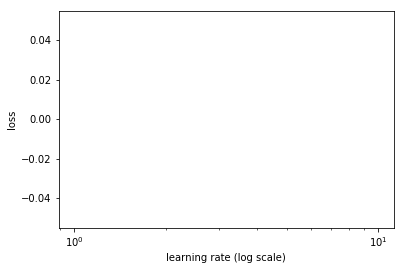

In [45]:
m.sched.plot(100)

In [47]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [49]:
m.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  0%|          | 0/8687 [00:00<?, ?it/s]


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




  1%|          | 85/8687 [00:06<10:19, 13.90it/s, loss=nan]


  2%|▏         | 171/8687 [00:11<09:17, 15.28it/s, loss=nan]


  3%|▎         | 257/8687 [00:16<08:52, 15.82it/s, loss=nan]


  4%|▍         | 341/8687 [00:21<08:42, 15.97it/s, loss=nan]


  5%|▍         | 427/8687 [00:26<08:31, 16.16it/s, loss=nan]


  6%|▌         | 513/8687 [00:31<08:21, 16.31it/s, loss=nan]


  7%|▋         | 598/8687 [00:36<08:14, 16.37it/s, loss=nan]


  8%|▊         | 695/8687 [00:41<07:54, 16.85it/s, loss=nan]


  9%|▉         | 791/8687 [00:45<07:39, 17.20it/s, loss=nan]


 10%|█         | 887/8687 [00:50<07:26, 17.48it/s, loss=nan]


 11%|█▏        | 983/8687 [00:55<07:15, 17.71it/s, loss=nan]


 12%|█▏        | 1076/8687 [01:00<07:05, 17.87it/s, loss=nan]


 13%|█▎        | 1172/8687 [01:04<06:56, 18.06it/s, loss=nan]


 15%|█▍        | 1265/8687 [01:09<06:48, 18.18it/s, loss=nan]


 16%|█▌        | 1361/8687 [01:14<06:39, 18.33it/s, loss=nan]


 17%|█▋        | 1454/8687 [01:18<06:32, 18.41it/s, loss=nan]


 18%|█▊        | 1550/8687 [01:23<06:25, 18.54it/s, loss=nan]


 19%|█▉        | 1643/8687 [01:28<06:18, 18.60it/s, loss=nan]


 20%|██        | 1739/8687 [01:32<06:11, 18.70it/s, loss=nan]


 21%|██        | 1832/8687 [01:37<06:05, 18.75it/s, loss=nan]


 22%|██▏       | 1928/8687 [01:42<05:58, 18.84it/s, loss=nan]


 23%|██▎       | 2021/8687 [01:47<05:53, 18.88it/s, loss=nan]


 24%|██▍       | 2117/8687 [01:51<05:46, 18.95it/s, loss=nan]


 25%|██▌       | 2210/8687 [01:56<05:41, 18.99it/s, loss=nan]


 27%|██▋       | 2306/8687 [02:01<05:34, 19.05it/s, loss=nan]


 28%|██▊       | 2399/8687 [02:05<05:29, 19.08it/s, loss=nan]


 29%|██▊       | 2495/8687 [02:10<05:23, 19.13it/s, loss=nan]


 30%|██▉       | 2588/8687 [02:15<05:18, 19.15it/s, loss=nan]


 31%|███       | 2684/8687 [02:19<05:12, 19.20it/s, loss=nan]


 32%|███▏      | 2777/8687 [02:24<05:07, 19.22it/s, loss=nan]


 33%|███▎      | 2873/8687 [02:29<05:01, 19.26it/s, loss=nan]


 34%|███▍      | 2966/8687 [02:33<04:56, 19.28it/s, loss=nan]


 35%|███▌      | 3062/8687 [02:38<04:51, 19.32it/s, loss=nan]


 36%|███▋      | 3155/8687 [02:43<04:46, 19.33it/s, loss=nan]


 37%|███▋      | 3251/8687 [02:47<04:40, 19.37it/s, loss=nan]


 38%|███▊      | 3344/8687 [02:52<04:35, 19.38it/s, loss=nan]


 40%|███▉      | 3440/8687 [02:57<04:30, 19.41it/s, loss=nan]


 41%|████      | 3533/8687 [03:01<04:25, 19.42it/s, loss=nan]


 42%|████▏     | 3629/8687 [03:06<04:20, 19.45it/s, loss=nan]


 43%|████▎     | 3722/8687 [03:11<04:15, 19.46it/s, loss=nan]


 44%|████▍     | 3818/8687 [03:15<04:09, 19.48it/s, loss=nan]


 45%|████▌     | 3911/8687 [03:20<04:05, 19.49it/s, loss=nan]


 46%|████▌     | 4007/8687 [03:25<03:59, 19.51it/s, loss=nan]


 47%|████▋     | 4100/8687 [03:30<03:54, 19.52it/s, loss=nan]


 48%|████▊     | 4196/8687 [03:34<03:49, 19.54it/s, loss=nan]


 49%|████▉     | 4289/8687 [03:39<03:44, 19.55it/s, loss=nan]


 50%|█████     | 4385/8687 [03:44<03:39, 19.57it/s, loss=nan]


 52%|█████▏    | 4478/8687 [03:48<03:35, 19.58it/s, loss=nan]


 53%|█████▎    | 4574/8687 [03:53<03:29, 19.60it/s, loss=nan]


 54%|█████▎    | 4667/8687 [03:58<03:25, 19.60it/s, loss=nan]


 55%|█████▍    | 4763/8687 [04:02<03:20, 19.62it/s, loss=nan]


 56%|█████▌    | 4856/8687 [04:07<03:15, 19.62it/s, loss=nan]


 57%|█████▋    | 4952/8687 [04:12<03:10, 19.64it/s, loss=nan]


 58%|█████▊    | 5045/8687 [04:16<03:05, 19.64it/s, loss=nan]


 59%|█████▉    | 5141/8687 [04:21<03:00, 19.66it/s, loss=nan]


 60%|██████    | 5234/8687 [04:26<02:55, 19.66it/s, loss=nan]


 61%|██████▏   | 5330/8687 [04:30<02:50, 19.68it/s, loss=nan]


 62%|██████▏   | 5423/8687 [04:35<02:45, 19.68it/s, loss=nan]


 64%|██████▎   | 5519/8687 [04:40<02:40, 19.69it/s, loss=nan]


 65%|██████▍   | 5612/8687 [04:44<02:36, 19.69it/s, loss=nan]


 66%|██████▌   | 5708/8687 [04:49<02:31, 19.71it/s, loss=nan]


 67%|██████▋   | 5801/8687 [04:54<02:26, 19.71it/s, loss=nan]


 68%|██████▊   | 5897/8687 [04:59<02:21, 19.72it/s, loss=nan]


 69%|██████▉   | 5990/8687 [05:03<02:16, 19.72it/s, loss=nan]


 70%|███████   | 6086/8687 [05:08<02:11, 19.74it/s, loss=nan]


 71%|███████   | 6179/8687 [05:13<02:07, 19.74it/s, loss=nan]


 72%|███████▏  | 6275/8687 [05:17<02:02, 19.75it/s, loss=nan]


 73%|███████▎  | 6368/8687 [05:22<01:57, 19.75it/s, loss=nan]


 74%|███████▍  | 6464/8687 [05:27<01:52, 19.76it/s, loss=nan]


 75%|███████▌  | 6557/8687 [05:31<01:47, 19.76it/s, loss=nan]


 77%|███████▋  | 6653/8687 [05:36<01:42, 19.78it/s, loss=nan]


 78%|███████▊  | 6746/8687 [05:41<01:38, 19.78it/s, loss=nan]


 79%|███████▉  | 6842/8687 [05:45<01:33, 19.79it/s, loss=nan]


 80%|███████▉  | 6935/8687 [05:50<01:28, 19.79it/s, loss=nan]


 81%|████████  | 7031/8687 [05:55<01:23, 19.80it/s, loss=nan]


 82%|████████▏ | 7124/8687 [05:59<01:18, 19.80it/s, loss=nan]


 83%|████████▎ | 7220/8687 [06:04<01:14, 19.81it/s, loss=nan]


 84%|████████▍ | 7313/8687 [06:09<01:09, 19.81it/s, loss=nan]


 85%|████████▌ | 7409/8687 [06:13<01:04, 19.82it/s, loss=nan]


 86%|████████▋ | 7502/8687 [06:18<00:59, 19.81it/s, loss=nan]


 87%|████████▋ | 7598/8687 [06:23<00:54, 19.82it/s, loss=nan]


 89%|████████▊ | 7691/8687 [06:27<00:50, 19.82it/s, loss=nan]


 90%|████████▉ | 7787/8687 [06:32<00:45, 19.83it/s, loss=nan]


 91%|█████████ | 7880/8687 [06:37<00:40, 19.83it/s, loss=nan]


 92%|█████████▏| 7976/8687 [06:41<00:35, 19.84it/s, loss=nan]


 93%|█████████▎| 8069/8687 [06:46<00:31, 19.84it/s, loss=nan]


 94%|█████████▍| 8165/8687 [06:51<00:26, 19.85it/s, loss=nan]


 95%|█████████▌| 8258/8687 [06:56<00:21, 19.85it/s, loss=nan]


 96%|█████████▌| 8354/8687 [07:00<00:16, 19.86it/s, loss=nan]


 97%|█████████▋| 8447/8687 [07:05<00:12, 19.86it/s, loss=nan]


 98%|█████████▊| 8543/8687 [07:10<00:07, 19.87it/s, loss=nan]


 99%|█████████▉| 8636/8687 [07:14<00:02, 19.86it/s, loss=nan]


100%|██████████| 8687/8687 [07:17<00:00, 19.87it/s, loss=nan]
                                                             [  0.  nan  nan]

  0%|          | 39/8687 [00:03<11:38, 12.38it/s, loss=nan]


  1%|          | 87/8687 [00:05<09:43, 14.74it/s, loss=nan]


KeyboardInterrupt: 

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)